# Preparación del entorno

In [4]:
!pip install gensim

In [41]:
from google.colab import drive
import zipfile
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
!mkdir ~/.kaggle
!cp /content/gdrive/MyDrive/Colab\ Notebooks/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
with zipfile.ZipFile("imdb-dataset-of-50k-movie-reviews.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Preprocesamiento

Tokenización

In [10]:
df["tokens"] = df["review"].apply(word_tokenize)
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[One, of, the, other, reviewers, has, mentione..."
1,A wonderful little production. <br /><br />The...,positive,"[A, wonderful, little, production, ., <, br, /..."
2,I thought this was a wonderful way to spend ti...,positive,"[I, thought, this, was, a, wonderful, way, to,..."
3,Basically there's a family where a little boy ...,negative,"[Basically, there, 's, a, family, where, a, li..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, 's, ``, Love, in, the, Time, ..."


Eliminación de stopwords

In [11]:
stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[One, reviewers, mentioned, watching, 1, Oz, e..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, ., <, br, /, >..."
2,I thought this was a wonderful way to spend ti...,positive,"[thought, wonderful, way, spend, time, hot, su..."
3,Basically there's a family where a little boy ...,negative,"[Basically, 's, family, little, boy, (, Jake, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, 's, ``, Love, Time, Money, ''..."


Lematización

In [12]:
nlp = spacy.load("en_core_web_sm")

In [13]:
def lemmatization(text):
  doc = nlp(" ".join(text))
  return [token.lemma_ for token in doc]

In [14]:
df['tokens'] = df['tokens'].apply(lemmatization)
df.head()

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[one, reviewer, mention, watch, 1, Oz, episode..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, ., <, br, /, >..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wonderful, way, spend, time, hot, summ..."
3,Basically there's a family where a little boy ...,negative,"[basically, 's, family, little, boy, (, Jake, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[Petter, Mattei, 's, `, `, Love, Time, Money, ..."


# Word embedding (word2vec) model

Creación del modelo

In [15]:
model_w2v = Word2Vec(
    sentences=df['tokens'],
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1  # Skip-gram
)

Vectorización

In [17]:
def get_text_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

In [18]:
df['vector'] = df['tokens'].apply(lambda x: get_text_vector(x, model_w2v))

Codificación de etiquetas

In [19]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})

División del dataset

In [21]:
X = np.vstack(df['vector'].values)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamiento del modelo

In [34]:
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

Evaluación del modelo

In [35]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      4961
           1       0.87      0.87      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# Visualización

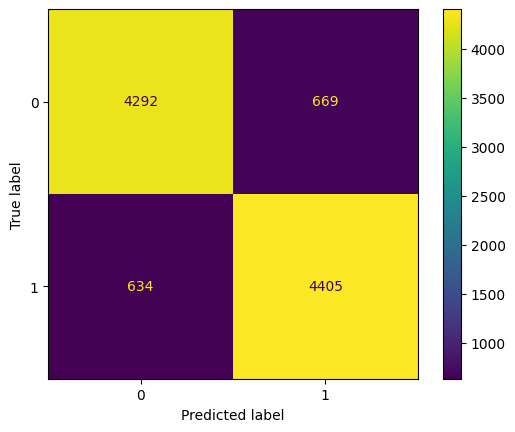

In [37]:
matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=matrix).plot()

Text(0.5, 1.0, 'Distribución de opiniones')

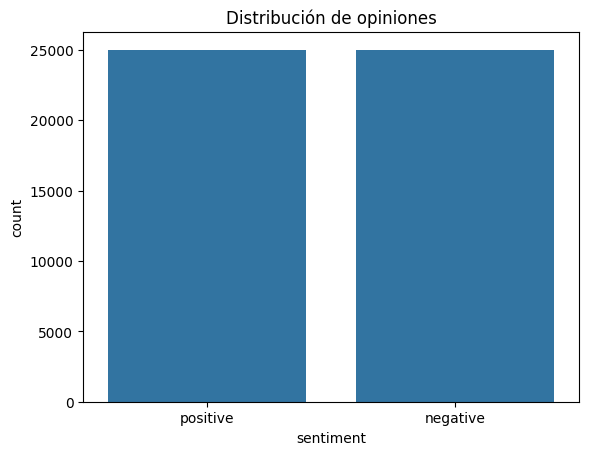

In [43]:
sns.countplot(x='sentiment', data=df)
plt.title("Distribución de opiniones")

<Axes: title={'center': 'Palabras negativas más frecuentes'}, xlabel='Palabra'>

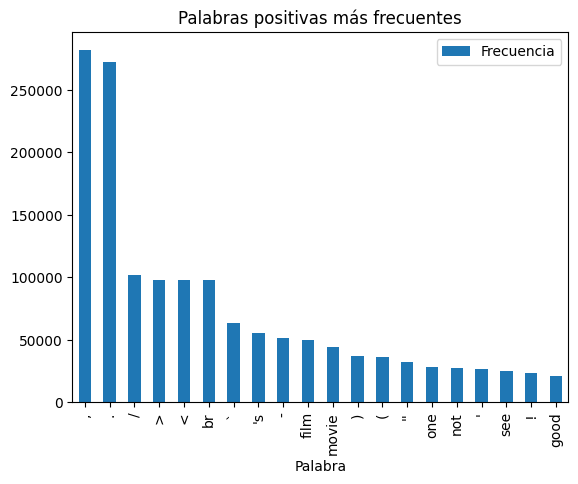

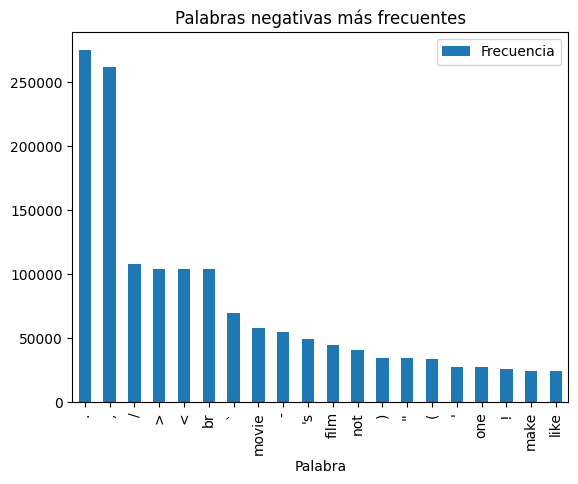

In [42]:
positive_words = [word for tokens in df[df['sentiment']=='positive']['tokens'] for word in tokens]
negative_words = [word for tokens in df[df['sentiment']=='negative']['tokens'] for word in tokens]

pos_freq = Counter(positive_words).most_common(20)
neg_freq = Counter(negative_words).most_common(20)


pd.DataFrame(pos_freq, columns=['Palabra', 'Frecuencia']).plot.bar(x='Palabra', title='Palabras positivas más frecuentes')
pd.DataFrame(neg_freq, columns=['Palabra', 'Frecuencia']).plot.bar(x='Palabra', title='Palabras negativas más frecuentes')